In [1]:
import serial
from datetime import datetime
import numpy as np
import pandas as pd
import time
import threading

In [2]:
# Read Serial Data from Arduino
def serial_data_read():
    # Open Serial COM Port
    Arduino_serial = serial.Serial("COM4", 9600)
    # Read Data from Serial COM Port
    ser_data = Arduino_serial.readline().strip()
    return ser_data

In [3]:
# Open Serial COM Port
Arduino_serial = serial.Serial("COM4", 9600)

In [4]:
# Read Data from Serial COM Port(
import pandas as pd
import numpy as np

hrt_data = []
threshold = 550

x = 0

with open('testData.csv','w') as f:
    while(x < 2000):
        x += 1
        ser_data = Arduino_serial.readline().strip()
        if (int(ser_data.decode()) > threshold):
            print(ser_data.decode())
            f.write(ser_data.decode())
            f.write('\n')

578
720
825
899
943
959
963
950
928
904
875
845
815
791
772
755
745
738
731
728
726
729
729
733
733
738
742
745
750
753
757
757
758
754
754
752
749
747
743
741
739
739
737
734
738
737
739
741
741
743
744
745
746
743
745
748
755
767
777
791
803
814
824
833
834
835
829
824
814
805
795
782
771
760
751
748
741
742
741
743
746
752
755
758
760
764
762
762
759
759
757
758
754
755
753
754
754
755
757
756
758
757
756
757
758
763
767
776
788
802
814
827
839
847
854
855
850
844
833
823
809
794
783
771
761
757
750
753
752
756
761
767
771
775
779
780
779
777
775
773
770
765
763
762
760
760
760
758
758
759
762
760
763
766
765
768
772
778
792
805
825
847
866
889
901
918
920
919
913
899
886
868
850
831
809
791
778
765
758
752
750
752
753
760
764
771
775
778
779
779
776
777
775
772
768
764
763
759
761
762
759
760
758
760
760
763
763
763
764
769
777
791
809
833
861
887
911
927
936
938
929
915
894
872
850
831
812
793
777
769
756
751
746
747
750
750
755
760
765
769
771
771
770
766
765
761
758
757
752
748


In [5]:
df = pd.read_csv('testData.csv')
df.columns = ['Heart_Rate']
df.head()

,Heart_Rate
0,720
1,825
2,899
3,943
4,959


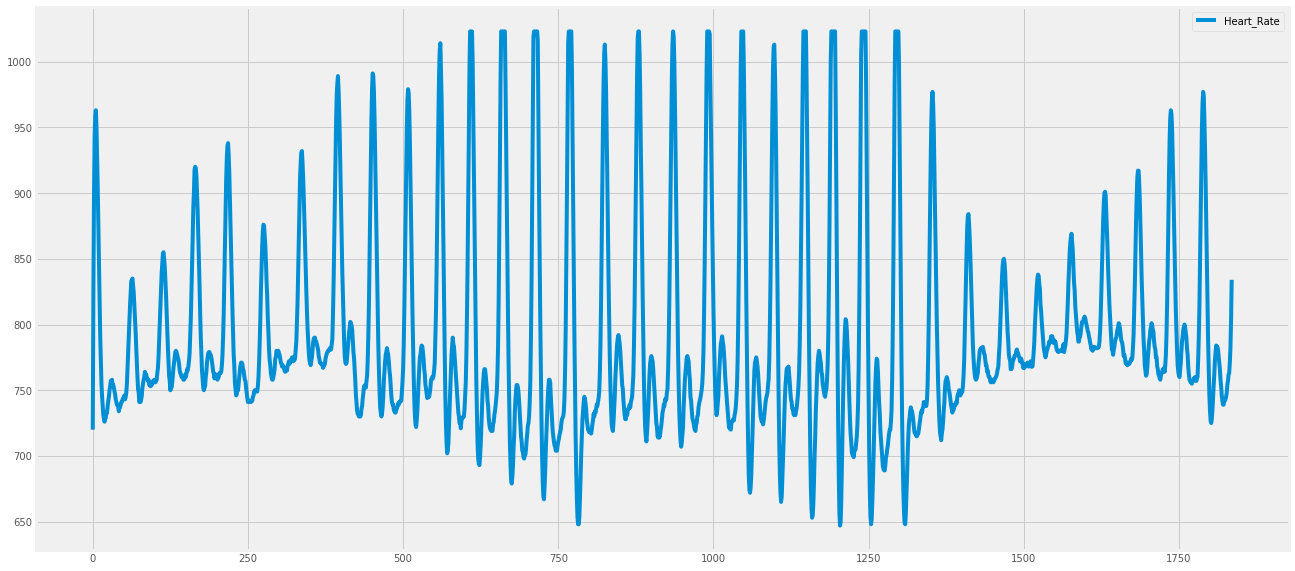

In [7]:
# Read Data from Serial COM Port(
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline

plt.figure(figsize=(20,10))
plt.plot(df.Heart_Rate, label='Heart_Rate')
plt.legend()

In [8]:
#Calculate moving average with 0.75s in both directions, then append do dataset
hrw = 0.75 #One-sided window size, as proportion of the sampling frequency
fs = 100 #The example dataset was recorded at 100Hz
mov_avg = df['Heart_Rate'].rolling(int(hrw*fs)).mean() #Calculate moving average

In [9]:
import math

#Impute where moving average function returns NaN, which is the beginning of the signal where x hrw
avg_hr = (np.mean(df.Heart_Rate))
mov_avg = [avg_hr if math.isnan(x) else x for x in mov_avg]
mov_avg = [x*1.2 for x in mov_avg] #For now we raise the average by 20% to prevent the secondary heart contraction from interfering, in part 2 we will do this dynamically
df['hart_rollingmean'] = mov_avg #Append the moving average to the dataframe

In [10]:
#Mark regions of interest
window = []
peaklist = []
listpos = 0 #We use a counter to move over the different data columns
for datapoint in df.Heart_Rate:
    rollingmean = df.hart_rollingmean[listpos] #Get local mean
    if (datapoint < rollingmean) and (len(window) < 1): #If no detectable R-complex activity -> do nothing
        listpos += 1
    elif (datapoint > rollingmean): #If signal comes above local mean, mark ROI
        window.append(datapoint)
        listpos += 1
    else: #If signal drops below local mean -> determine highest point
        maximum = max(window)
        beatposition = listpos - len(window) + (window.index(max(window))) #Notate the position of the point on the X-axis
        peaklist.append(beatposition) #Add detected peak to list
        window = [] #Clear marked ROI
        listpos += 1

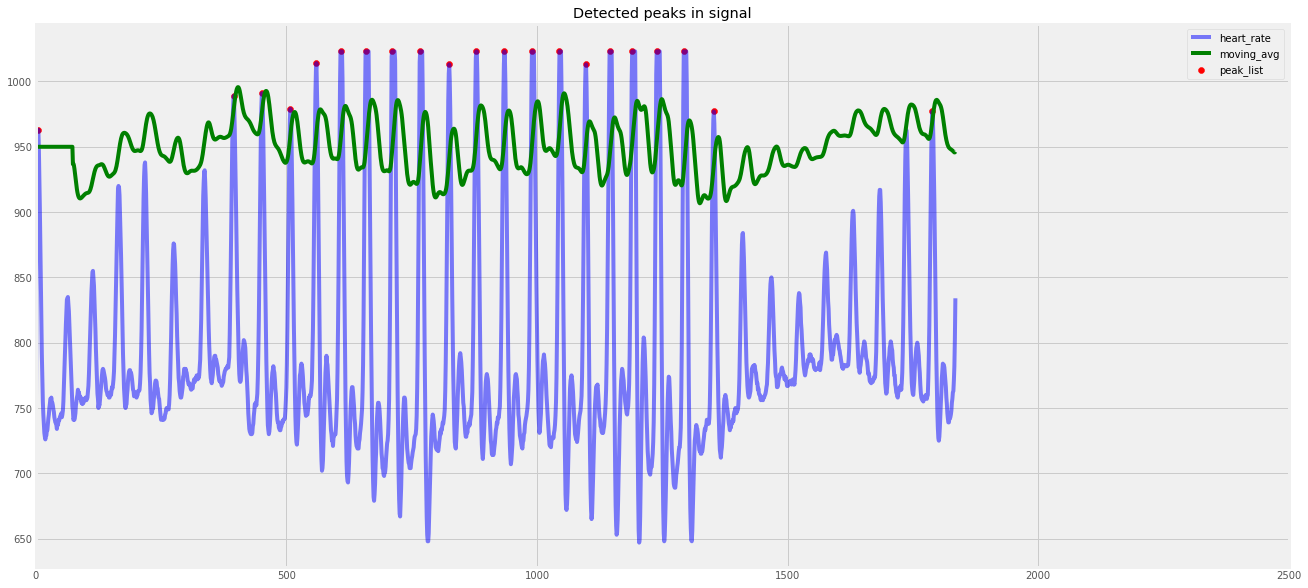

In [13]:
plt.figure(figsize=(20,10))
ybeat = [df.Heart_Rate[x] for x in peaklist] #Get the y-value of all peaks for plotting purposes
plt.title("Detected peaks in signal")
plt.xlim(0,2500)
plt.plot(df.Heart_Rate, alpha=0.5, color='blue', label='heart_rate') #Plot semi-transparent HR
plt.plot(mov_avg, color ='green', label='moving_avg') #Plot moving average
plt.scatter(peaklist, ybeat, color='red', label='peak_list') #Plot detected peaks
plt.legend()
plt.show()